Churn Predictions Model

In [44]:
#import package

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

import os
import pickle


from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import shap

In [2]:
#load data
#data directory
PICKLE_TRAIN_DIR=os.path.join("..","processed_data","train_data.pkl")
PICKLE_HISTORY_DIR=os.path.join("..","processed_data","history_data.pkl")

In [3]:
#load data into dataframe
hist_data= pd.read_pickle(PICKLE_HISTORY_DIR)
train = pd.read_pickle(PICKLE_TRAIN_DIR)

In [4]:
#merge train and hist data to analysis
train = pd.merge(train, hist_data, on = 'id')

In [5]:
#splitting data
y = train['churn']
X = train.drop(labels = ['id', 'churn'], axis =1)

In [6]:
#the test ratio we pick is 75%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 5)

In [7]:
#modeling - xgboost
model_xgb = xgb.XGBClassifier(learning_rate = 0.1, max_depth=6, n_estimators = 500, n_jobs = -1, eval_metric='logloss')
result_sgb = model_xgb.fit(X_train, y_train)

C:\Users\BlackChip\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [8]:
#model evaluation
def evaluate(model_,X_test_,y_test_):

# Get the model predictions
    prediction_test_=model_.predict(X_test_)
# Print the evaluation metrics as pandas dataframe
    results=pd.DataFrame({"Accuracy": [metrics.accuracy_score(y_test_,prediction_test_)],#
                          "Precision": [metrics.precision_score(y_test_,prediction_test_)],
                          "Recall/Sensitivity": [metrics.recall_score(y_test_,prediction_test_)]})
# For a more detailed report
#print(metrics.classification_report(y_test_, prediction_test_))
    return results

In [9]:
evaluate (model_xgb,X_test,y_test)

,Accuracy,Precision,Recall/Sensitivity
0,0.907803,0.641509,0.088083


In [10]:
#modeling - ramdom forest
model_rf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
result_rf = model_rf.fit(X_train, y_train)

In [11]:
evaluate (model_rf,X_test,y_test)

,Accuracy,Precision,Recall/Sensitivity
0,0.907555,0.818182,0.046632


In [12]:
#cross validation to test the model
#Xgboost
cv = cross_val_score(model_xgb,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

C:\Users\BlackChip\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0.90310559 0.9010352  0.90223695 0.9067937  0.9026512 ]
0.903164528518082


In [13]:
#random forest
cv = cross_val_score(model_rf,X_train,y_train,cv=5)
print(cv)
print(cv.mean())

[0.90600414 0.90227743 0.90389395 0.9043082  0.9051367 ]
0.9043240860336788


#Model finetuning

In [15]:
#create the random grid
params = {
    'min_child_weight': [i for i in np.arange(1,15,1)],
    'gamma': [i for i in np.arange(0,6,0.5)],
    'subsample': [i for i in np.arange(0,1.1,0.1)],
    'colsample_bytree': [i for i in np.arange(0,1.1,0.1)],
    'max_depth': [i for i in np.arange(1,15,1)],    
    'scale_pos_weight':[i for i in np.arange(1,15,1)],
    'learning_rate': [i for i in np.arange(0,0.15,0.01)],
    'n_estimators': [i for i in np.arange(0,2000,100)]
    }

In [16]:
#create base model
xg = xgb.XGBClassifier(objective='binary:logistic',silent=True,nthread=1)

In [25]:
# Random search of parameters, using 5
xg_random =RandomizedSearchCV(xg,param_distributions=params,
                              n_iter=1,scoring="roc_auc",
                              n_jobs=4,cv=5,verbose=3,random_state=1001)

# Fit the random search model
xg_random.fit(X_train,y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   5 | elapsed:    7.8s remaining:   11.7s
[Parallel(n_jobs=4)]: Done   5 out of   5 | elapsed:    9.2s finished
C:\Users\BlackChip\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[08:45:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:45:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           n_estimators=100,...
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                        

In [26]:
best_random=xg_random.best_params_
best_random

{'subsample': 0.0,
 'scale_pos_weight': 6,
 'n_estimators': 300,
 'min_child_weight': 10,
 'max_depth': 12,
 'learning_rate': 0.1,
 'gamma': 2.5,
 'colsample_bytree': 1.0}

In [35]:
# Create the parameter grid based on the results of random search
param_grid = {
    'subsample': [0.1],
 'scale_pos_weight': [6],
 'n_estimators': [300],
 'min_child_weight': [10],
 'max_depth': [12, 13, 14],
 'learning_rate': [0.005, 0.1],
 'gamma': [2.5],
 'colsample_bytree': [1.0]}


In [36]:
#create model
xg = xgb.XGBClassifier(objective='binary:logistic',silent=True,nthread=1)

In [37]:
# Instantiate the grid search model
grid_search=GridSearchCV(estimator=xg,param_grid=param_grid,cv=5,
                         n_jobs=-1,verbose=2,scoring="roc_auc")

In [38]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  1.6min finished
C:\Users\BlackChip\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[09:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:01:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, silent=True,
                                     subsample=None, tree_method=None,
                                     validate_parameters=None, verbos

In [39]:
best_grid = grid_search.best_params_
best_grid

{'colsample_bytree': 1.0,
 'gamma': 2.5,
 'learning_rate': 0.005,
 'max_depth': 12,
 'min_child_weight': 10,
 'n_estimators': 300,
 'scale_pos_weight': 6,
 'subsample': 0.1}

In [40]:
# Create a model with the parameters found
model_grid=xgb.XGBClassifier(objective='binary:logistic',silent=True,nthread=1,**best_grid)
model_grid.fit(X_train, y_train)

[09:02:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:02:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=2.5, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.005, max_delta_step=0, max_depth=12,
              min_child_weight=10, missing=nan, monotone_constraints='()',
              n_estimators=300, n_jobs=1, nthread=1, num_parallel_tree=1,
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=6,
              silent=True, subsample=0.1, tree_method='exact',
              validate_parameters=1, verbosity=None)

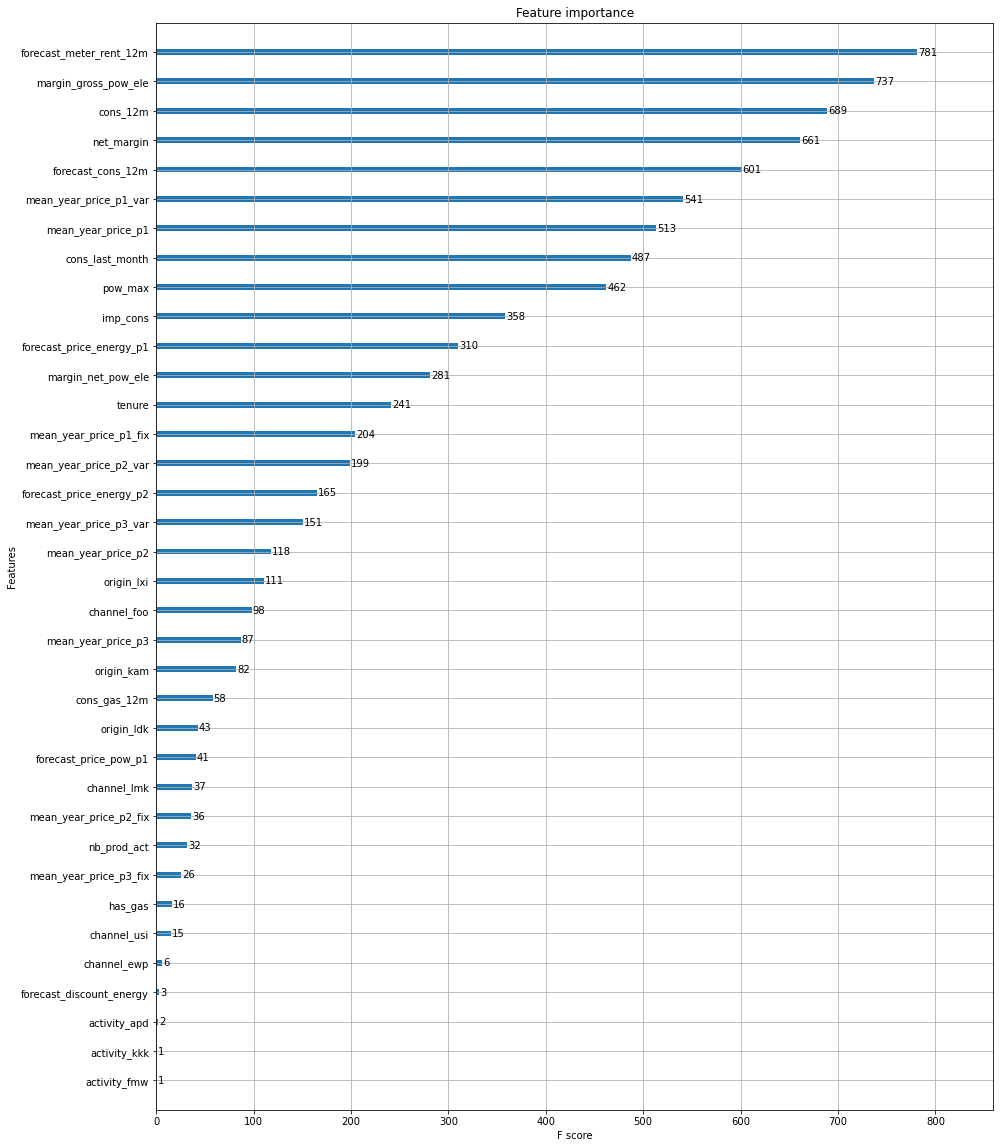

In [41]:
#features importance
fig,ax=plt.subplots(figsize=(15,20))
xgb.plot_importance(model_grid,ax=ax)

In the feature importance graph above we can see that forecast_meter-rent_12m and margin_gross_pow_ele
are the features that appear the most in our model and we could infere that these two features have a significant importnace in our model

SHAP - Features Importance

In [45]:
explainer = shap.TreeExplainer(model_grid)
shap_values=explainer.shap_values(X_test)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


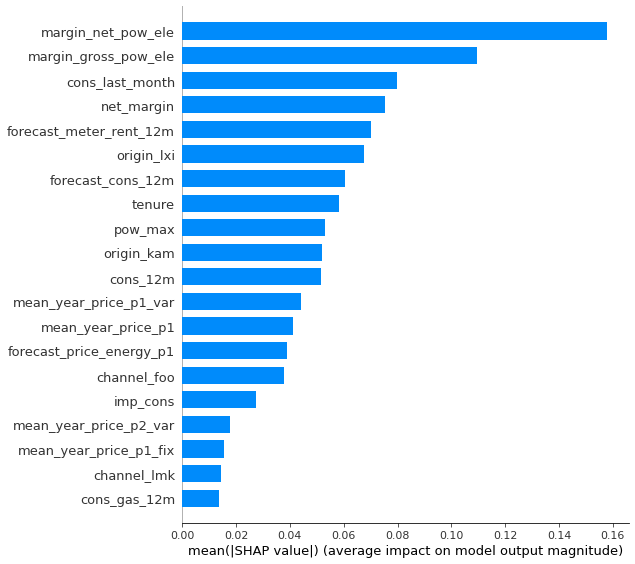

In [46]:
# Feature importance for class 1 - churn
shap.summary_plot(shap_values,X_test,plot_type='bar')

In the shap feature importance graph above we can see that margin_net_pow_ele and margin_gross_pow_ele
are the two features have a significant importnace in our model